#Relationship Extraction 
Extract from Any Web Articles using spaCy and Jupyter Notebook in 6 Steps

Origina Source -
https://hami-asmai.medium.com/relationship-extraction-from-any-web-articles-using-spacy-and-jupyter-notebook-in-6-steps-4444ee68763f


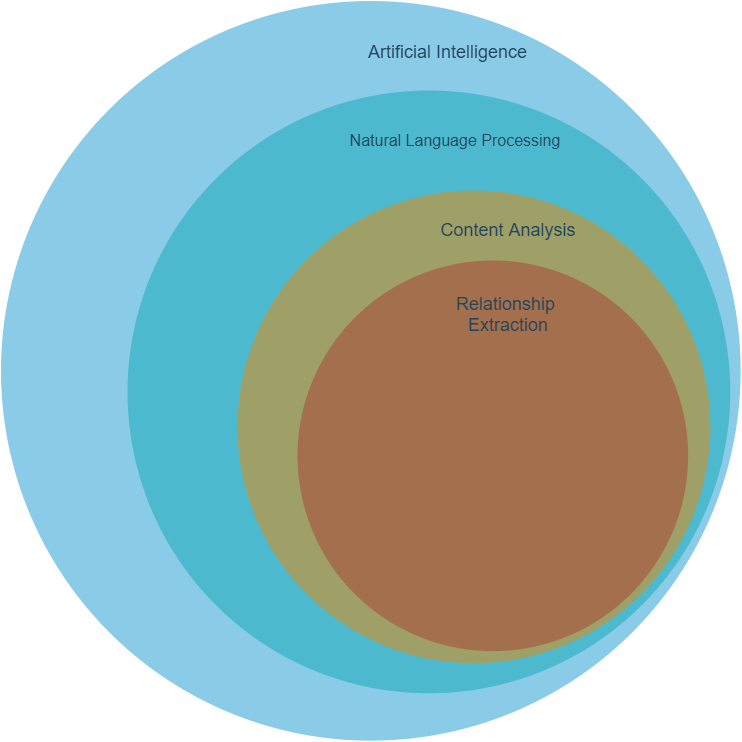

# Introduction
Natural Language Processing (NLP) is a branch of Artificial Intelligence, referring to the ability of a computer program to understand human language as it is spoken and written. A gentle overview of this field is well documented this this article: A Introduction to NLP.

Among the applications of NLP, there is a focus on Content Analysis for social media or web data mining, and one of the important aspect of Content Analysis is Relationship Extraction.

Relationship Extraction is the process of identification of relationships between different entities in a text. It involves identifying entities in a sentence and then performing the relation analysis between the entities identified.

What is spaCy?
SpaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python. SpaCy is designed specifically for production use and helps to build applications that process and “understand” large volumes of text. It can be used to build information extraction or natural language understanding systems, or to pre-process text for deep learning.

Another widely used library is NLTK where it is more research focused. NLTK provides ranges of options for algorithms to be used, while spaCy uses the latest and best algorithms available.

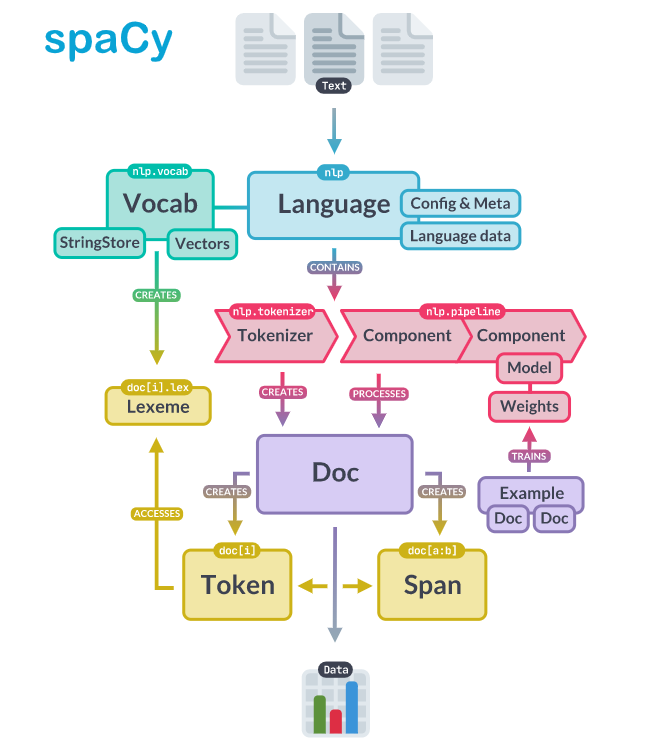

### The following are among the features that spaCy offers:

Tokenization: Segmenting text into words, punctuations marks etc.
Part-of-speech (POS) Tagging: Assigning word types to tokens, like verb or noun.
Dependency Parsing: Assigning syntactic dependency labels, describing the relations between individual tokens, like subject or object.
Lemmatization: Assigning the base forms of words. For example, the lemma of “was” is “be”, and the lemma of “rats” is “rat”.
Sentence Boundary Detection (SBD): Finding and segmenting individual sentences.
Named Entity Recognition (NER): Labelling named “real-world” objects, like persons, companies or locations.
There are many other important features provided by spaCy, which can be further explored in spaCy documentations.

For the next sections, we are going into the step-by-step process of Relationship Extraction from website.

Note: If you are totally new to jupyter notebook & python in general, you can visit Introduction to Jupyter for a quick introduction.

## Step 1: Install & Import Dependencies
To install spaCy, use the following command:

In [1]:
!python -m spacy download en_core_web_sm

2022-09-20 05:39:47.235292: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 14.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


It is also required to install pandas and bs4 (BeautifulSoup)

In [2]:
!pip install pandas
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


After installations, we need to import those libraries for usage in our code.

In [3]:
import re
import csv
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import urllib.request 
from bs4 import BeautifulSoup

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

## Step 2: Choose your desired Web Content, Scrape it and Save it into CSV format
In my experiment, I selected an article from rigzone.com about omicron impact to oil global market. If you would like to import different article, just replace the line 2 in my code below.

In [4]:
# indicate address for chosen URL
url = "https://www.rigzone.com/news/what_could_omicron_cost_global_oil_market-03-dec-2021-167199-article"

# open the URL for reading
html = urllib.request.urlopen(url)

# parsing the html file
htmlParse = BeautifulSoup(html, 'html.parser')

parsed_text = ""

for para in htmlParse.find_all("p"):
    #parsed_text_str += str(para.get_text())
    parsed_text = " ".join((parsed_text, str(para.get_text())))
    
    
sentences = [[i] for i in nlp(parsed_text).sents]
sentences[:10]

[[  
   var ssdl =], [ssdl || {}  
   ssdl.editorialMetaData = { 'Country' : 'All', 
  'Region' : 'All', 
  'company' : '', 
  'sector' : 'Industry_Headlines', 
  'industry_sector' : 'Downstream,Upstream', 
  'audience' : 'News', 
  'content_type' : 'About the Industry', 
  'company_sentiment' : 'Negative', 
  'author' : 'Andreas Exarheas', 
  'published_date' : '2021-12-03', 
  'tag' : 'People_on_the_Move,Govt_Regulatory,Political_Social_Unrest,Health_Safety_Environment,Analysis_Trends', 
  'longevity' : 'News', 
  'content_origin' : 'Original Content', 
  } 
    The new Omicron variant of Covid-19 could cost the global oil market as much as 2.9 million barrels per day of demand in the first quarter of next year, bringing total demand down to 95.7 million barrels per day, if it triggers more lockdowns or restrictions.], [That’s according to Rystad Energy, which warned that, if the variant spreads rapidly, oil demand could fall by 1.3 million barrels per day, to 97.8 million barrels pe

Line 4 to 12 are basically the code to read the webpage and save only texts into ‘parsed_text’ variable. The data stored in ‘parsed_text’ is as below.

Then, we split each sentence into different units in a list using the code in Line 15, where we save the output in the variable ‘sentences’. The output should look as snip below.

To save the data into CSV, we make use of the following code

In [5]:
myheaders = ['sentence']
myvalues = sentences
filename = 'article_text.csv'

with open(filename, 'w',newline='') as myfile:
    writer = csv.writer(myfile)
    writer.writerow(myheaders)
    writer.writerows(myvalues)

Above code will save the data stored in ‘sentences’ into a CSV with filename “article_text.csv”. The CSV file looks something like below

#Step 3: Manually Clean Data (if necessary) & Re-Import the CSV File
If you notice, there are some blank lines which are unnecessary for our further processing. At this stage, we will just manually delete those blank lines. (There should be a code to automate this process but I skipped it for now). After data cleaning, I saved the file into filename “article_text_clean.csv”. Then, data can be re-imported using following line of code.

In [6]:
csv_sentences = pd.read_csv("article_text.csv")

Output of it can be seen as below

## Step 4: Get entity pairs
The next step is to get entity pairs using the following Code:

In [7]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

The function above is basically can read any sentence and return two entities. For example, see the following usage.

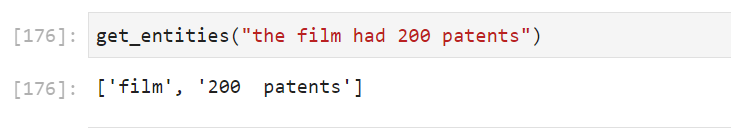

We then run the function throughout our texts imported from CSV file earlier.

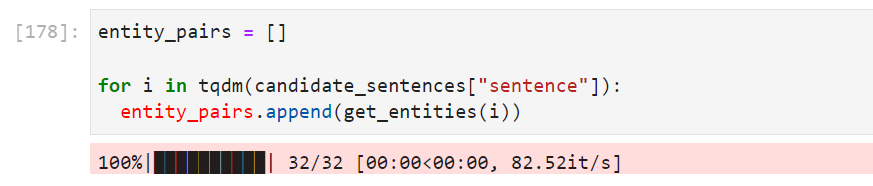

In [8]:
entity_pairs = []

for i in tqdm(csv_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 33/33 [00:00<00:00, 85.42it/s]


#Step 5: Get Relations for the entities
Now that we got the entity pairs for the article, next is to get the relation for each pairs. We make use of the following code.

In [9]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 
  return(span.text)

Below image snip shows how this function supposed to work:

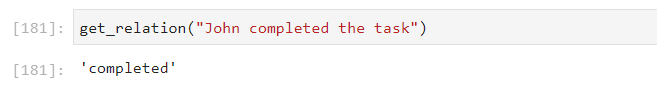

Now, using the function we apply to the CSV imported text:

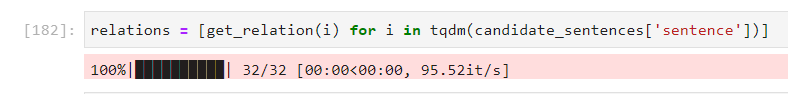

In [10]:
relations = [get_relation(i) for i in tqdm(csv_sentences['sentence'])]

100%|██████████| 33/33 [00:00<00:00, 89.60it/s]


We can display the relations summary as below:

In [11]:
pd.Series(relations).value_counts()[:50]

said in            2
added in           2
announced          2
is                 2
ssdl               1
said               1
think              1
contact            1
reported to        1
include            1
risen for          1
administered as    1
been               1
added              1
impacted           1
displayed          1
admitted           1
cost               1
highlighted        1
see                1
show               1
warned             1
’s                 1
fall by            1
hope               1
fall to            1
noted              1
according to       1
love               1
dtype: int64

# Step 6: Display Entity Relations into Graphs
The final step is to visualize the entity relations into a network graph.

To display everything (all entities and their relations), use the following code.

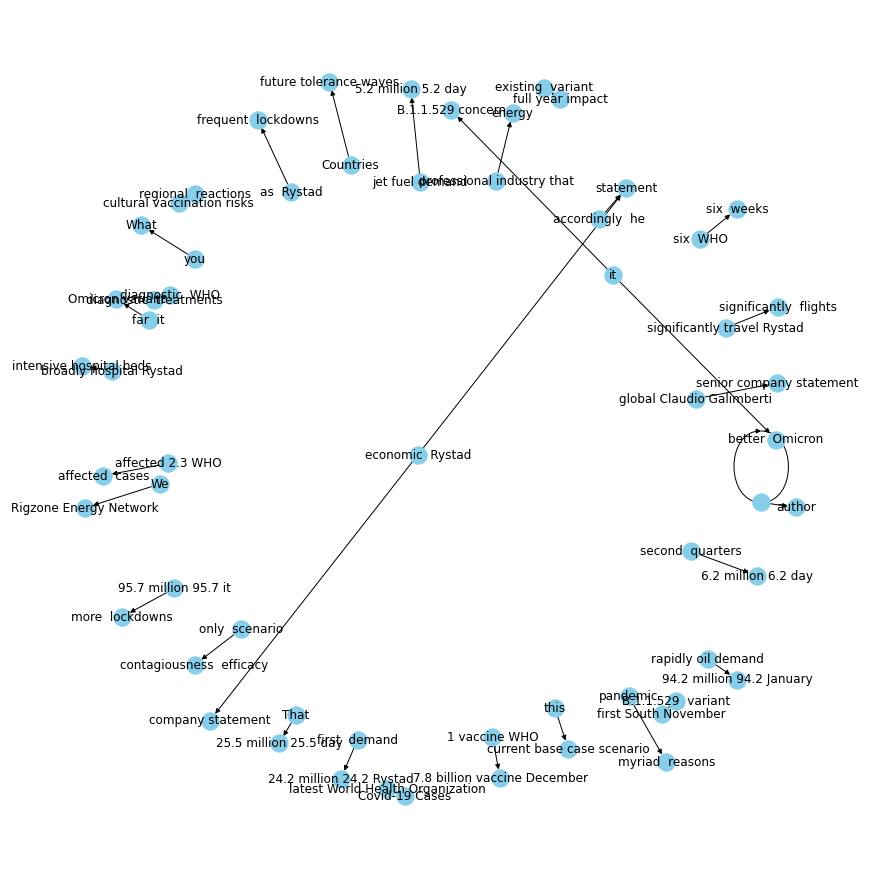

In [12]:

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Sometimes, it is not good to display everything because the visualization can be hardly readable. This usually happens to huge text because of large number of relation. An example of this “overcrowded” visualization is as below.

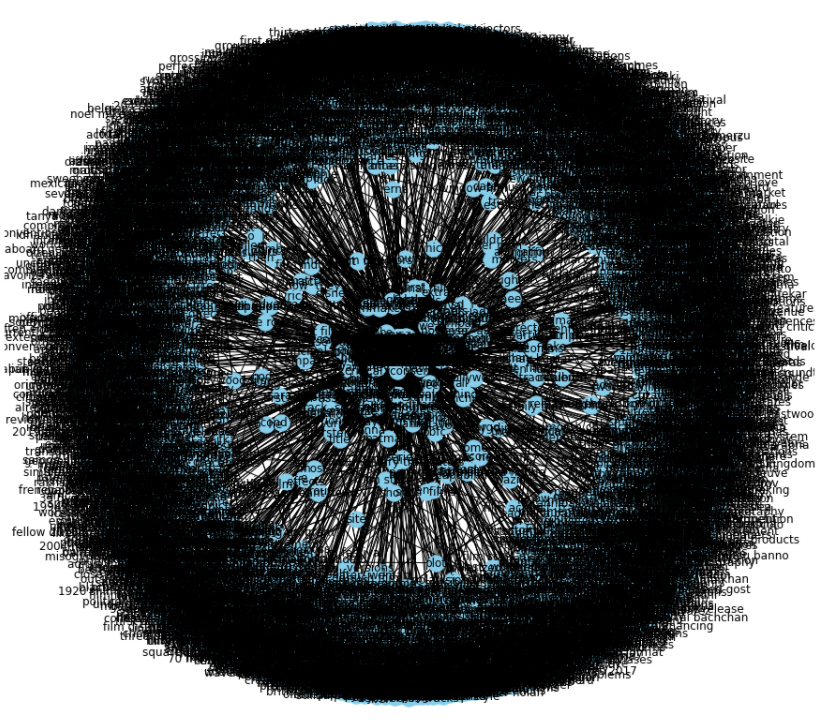

To mitigate above from happen, we can “filter” the relation for which one we want to display, by using the following code.

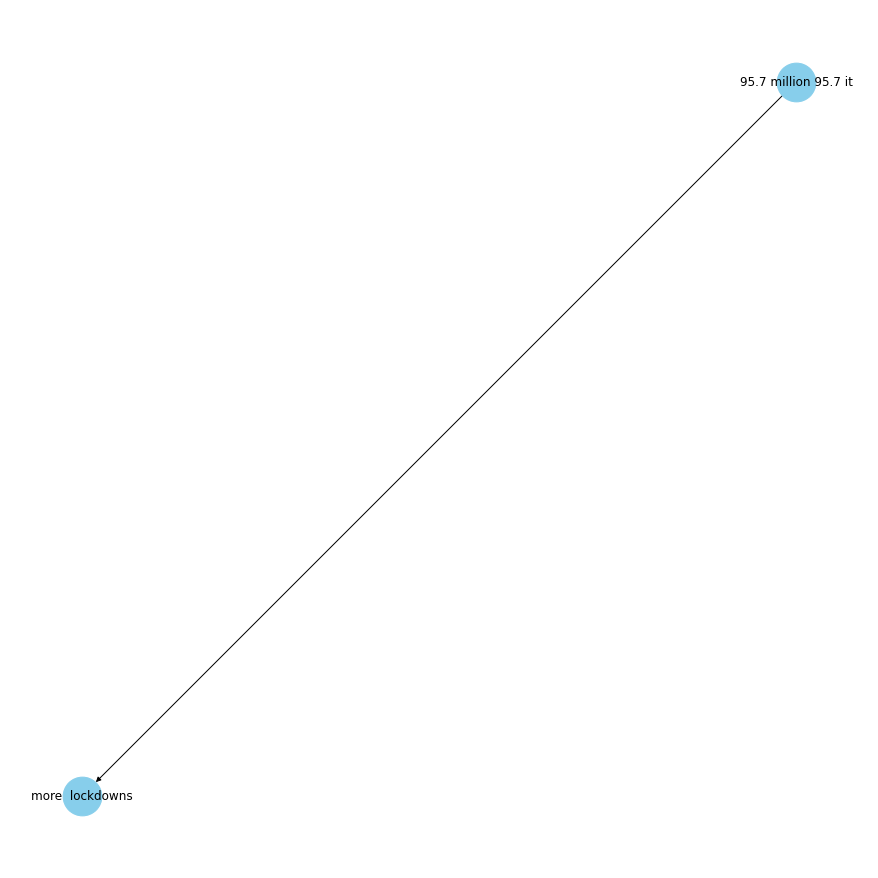

In [13]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="cost"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In code above, we filter using the relation “cost”. The graph (data using Rigzone article) will show below output.



You can always change what relation value do you want to apply for the filter by replacing the “cost” with another possible relation. Below is the output when I applied to another graph (Wiki_Sentences_V2.csv), using the relation “composed by”.

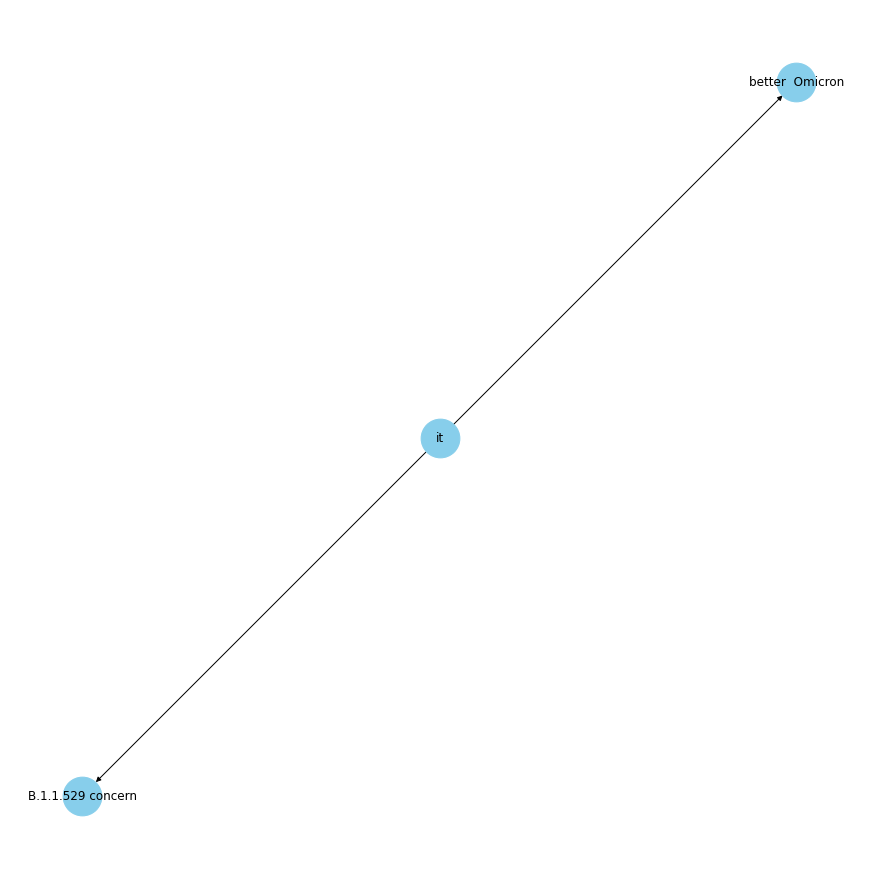

In [14]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="announced"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

# Conclusion
With above step-by-step guide, I hope you can see the possible use of relationship extraction. Obviously, much could be improved on the text analysis by the model and the visualization itself. By improving both of these, this particular subject could be applied in real business or academic application.

Full Code
The full code (in Jupyter Notebook) can be downloaded in my Github page: https://github.com/hamiasmaiX/web-relationextraction

Acknowledgement
This article is part of the course requirement by Professor Anton Kolonin in Application aspects of social data processing (Social intelligence technologies or Social computing) at Novosibirsk State University. (Anton’s medium page: https://aigents.medium.com/)

References
https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk
https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/
https://www.easytweaks.com/write-list-csv-python/
https://www.rigzone.com/news/what_could_omicron_cost_global_oil_market-03-dec-2021-167199-article


Now lets run a quick test to see if it can be used to find family relations

In [18]:
entity_pairs =[]

text = 'I went to see my grandma at the hospital yesterday with my brother we spent a bit of time there then my dad came and we left a few hours later'


entity_pairs.append(get_entities(text))
entity_pairs

[['we', 'time']]

In [19]:
relations = get_relation(text) 

relations

'came'

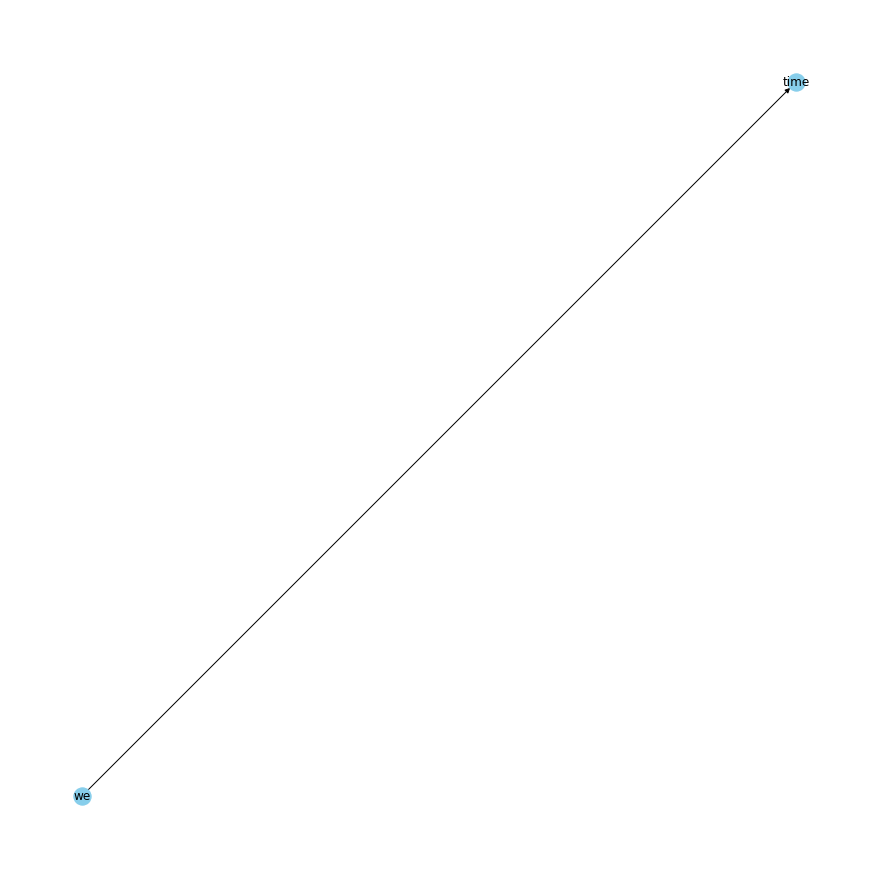

In [20]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

as you can see famly realtions are not found 